# Library

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd

In [10]:
# Download dataset


images_dir = os.path.join("./data/img_align_celeba")
attributes_file = os.path.join("./data/list_attr_celeba.csv")
land_mark = os.path.join("./data/list_landmarks_align_celeba.csv")
face_box = os.path.join("./data/list_bbox_celeba.csv")
partition = os.path.join("./data/list_eval_partition.csv")

obj = 20
batch_size = 128

In [11]:
file_path = "./data/identity_CelebA.txt"

# Load image labels into a DataFrame
image_labels = pd.read_csv(file_path, delim_whitespace=True, header=None, names=["image_name", "label"])

# Count the number of images per label
label_counts = image_labels["label"].value_counts()

# Filter labels with at least 29 images
valid_labels = label_counts[label_counts == 30].index

# Filter the DataFrame to keep only valid labels
filtered_image_labels = image_labels[image_labels["label"].isin(valid_labels)]

# Example usage: Print the number of valid labels and a preview of the filtered DataFrame
print(f"Number of valid labels: {len(valid_labels)}")
print(filtered_image_labels.head())

# Optional: Save the filtered DataFrame to a new file if needed
filtered_file_path = "./filtered_identity_CelebA.txt"
filtered_image_labels.to_csv(filtered_file_path, index=False, header=False, sep=" ")
print(f"Filtered labels saved to {filtered_file_path}")

C:\Users\parsak\AppData\Local\Temp\ipykernel_21512\2217787362.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  image_labels = pd.read_csv(file_path, delim_whitespace=True, header=None, names=["image_name", "label"])


Number of valid labels: 2343
   image_name  label
0  000001.jpg   2880
1  000002.jpg   2937
2  000003.jpg   8692
3  000004.jpg   5805
5  000006.jpg   4153
Filtered labels saved to ./filtered_identity_CelebA.txt


In [12]:
import random
import os
import pandas as pd

# Load the filtered labels DataFrame (from the previous step)
filtered_image_labels = pd.read_csv("./filtered_identity_CelebA.txt", delim_whitespace=True, header=None, names=["image_name", "label"])

# Extract the unique labels from the filtered data
unique_labels = filtered_image_labels["label"].unique()

# Randomly select 500 labels from the unique labels
selected_labels = random.sample(list(unique_labels), obj)

# Create a mapping from the original labels to new labels (0 to 499)
label_mapping = {original_label: new_label for new_label, original_label in enumerate(selected_labels, start=0)}

# Filter the dataset to include only images from the selected labels
selected_images = filtered_image_labels[filtered_image_labels["label"].isin(selected_labels)]

# Replace the original labels with the new labels in the filtered dataset
selected_images["label"] = selected_images["label"].map(label_mapping)

# Example: Print the first 5 rows of the updated DataFrame
print(selected_images.head())

# Optionally, save the updated DataFrame to a new file
selected_images_file = "./selected_500_labels_images_renamed.txt"
selected_images.to_csv(selected_images_file, index=False, header=False, sep=" ")
print(f"500 selected labels and images saved to {selected_images_file}")


     image_name  label
31   000059.jpg      5
47   000105.jpg      9
170  000457.jpg     11
180  000485.jpg     13
226  000622.jpg      1
500 selected labels and images saved to ./selected_500_labels_images_renamed.txt


C:\Users\parsak\AppData\Local\Temp\ipykernel_21512\768325506.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  filtered_image_labels = pd.read_csv("./filtered_identity_CelebA.txt", delim_whitespace=True, header=None, names=["image_name", "label"])
C:\Users\parsak\AppData\Local\Temp\ipykernel_21512\768325506.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_images["label"] = selected_images["label"].map(label_mapping)


In [13]:
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the image preprocessing transform (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet18 input size
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet stats
])

# Custom dataset class
class CelebADataset(Dataset):
    def __init__(self, image_labels_df, images_dir, transform=None):
        self.image_labels_df = image_labels_df
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_labels_df)

    def __getitem__(self, idx):
        # Get the image path and label
        image_name = self.image_labels_df.iloc[idx, 0]
        label = self.image_labels_df.iloc[idx, 1]

        # Open the image
        image_path = f"{self.images_dir}/{image_name}"
        image = Image.open(image_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Split the selected_images into train, validation, and test sets directly
train_data, temp_data = train_test_split(
    selected_images,
    train_size=0.8,
    stratify=selected_images["label"]
)
valid_data, test_data = train_test_split(
    temp_data,
    train_size=0.5,  # Split the remaining 20% equally
    stratify=temp_data["label"]
)

# Create datasets
train_dataset = CelebADataset(train_data, images_dir, transform=transform)
valid_dataset = CelebADataset(valid_data, images_dir, transform=transform)
test_dataset = CelebADataset(test_data, images_dir, transform=transform)

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Print the number of batches for each DataLoader
print(f"Train DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(valid_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")


Train DataLoader: 4 batches
Validation DataLoader: 1 batches
Test DataLoader: 1 batches


In [14]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(labels)
    break  # Break after the first batch to avoid printing all batches

for images, labels in valid_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(labels)
    break  # Break after the first batch to avoid printing all batches

for images, labels in test_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(labels)
    break  # Break after the first batch to avoid printing all batches



Images shape: torch.Size([128, 3, 224, 224])
Labels shape: torch.Size([128])
tensor([16,  4,  1, 19, 15,  2, 15,  6,  4,  6, 19,  5, 17,  5,  5, 11,  9, 11,
         7,  0,  7, 15, 18,  2, 18, 18,  6,  9,  6, 14, 11, 12, 13, 10,  9,  5,
         6, 16,  1, 15, 12, 17,  2, 18, 12,  2,  7,  0, 11, 10,  8,  6,  8,  4,
        18, 11, 10,  3, 13, 11,  8, 19, 15, 12,  4, 12, 19, 12,  3, 15,  8,  5,
         6,  6,  5, 17, 14, 16,  2, 18,  7,  2, 15,  7,  5,  4, 19,  8,  1,  9,
         9,  2,  5, 15,  0,  7,  4, 12, 11, 11,  9, 19,  7,  7,  2,  9, 17, 14,
        17,  2, 18, 10, 11,  5,  9,  0, 13, 18, 19, 11, 19, 10, 10, 16, 14, 17,
         0, 19])
Images shape: torch.Size([60, 3, 224, 224])
Labels shape: torch.Size([60])
tensor([ 4, 18, 17,  7, 11, 13, 16,  0, 10,  3,  4,  5,  2,  1,  0,  8, 15, 10,
        17,  9, 19,  5, 17,  0,  8, 19, 13,  4, 14, 12,  8, 18,  2,  3,  6,  2,
        15, 14, 12, 19,  3, 18,  7,  1,  5,  9,  1,  7,  9,  6, 15, 11, 13, 11,
        16, 16, 14, 12, 10,  6]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torch



# Function to plot images in a grid
def plot_images(images, title="Images"):
    # Create a grid of images
    grid = make_grid(images, nrow=8, padding=2)

    # Convert to numpy array for plotting
    np_grid = grid.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC

    # Plot the grid
    plt.figure(figsize=(12, 12))
    plt.imshow(np_grid)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to get and plot images for a specific label from the dataset
def plot_images_by_label(label, train_dataset, valid_dataset, test_dataset, transform=None):
    # Get all images belonging to the given label from each dataset
    train_images = []
    train_labels = []

    for img, lbl in train_dataset:
        if lbl == label:
            train_images.append(img)
            train_labels.append(lbl)

    valid_images = []
    valid_labels = []

    for img, lbl in valid_dataset:
        if lbl == label:
            valid_images.append(img)
            valid_labels.append(lbl)

    test_images = []
    test_labels = []

    for img, lbl in test_dataset:
        if lbl == label:
            test_images.append(img)
            test_labels.append(lbl)

    # Plot the images for the train set
    if train_images:
        plot_images(train_images, title=f"Train Set - Label {label}")
    else:
        print(f"No images found for Label {label} in Train Set.")

    # Plot the images for the validation set
    if valid_images:
        plot_images(valid_images, title=f"Validation Set - Label {label}")
    else:
        print(f"No images found for Label {label} in Validation Set.")

    # Plot the images for the test set
    if test_images:
        plot_images(test_images, title=f"Test Set - Label {label}")
    else:
        print(f"No images found for Label {label} in Test Set.")

# Pick a label
label_to_plot = list(set(selected_images["label"]))[155]

# Call the function to plot images for the selected label
plot_images_by_label(label_to_plot, train_dataset, valid_dataset, test_dataset, transform=transform)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize the images for visualization
def denormalize(image_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HWC format
    image = std * image + mean  # Reverse normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] for valid image range
    return image

# Function to display images with labels from a DataLoader
def display_batch(data_loader, title="Batch"):
    # Get a batch of data
    images, labels = next(iter(data_loader))

    # Plot the images in a grid
    batch_size = len(images)
    plt.figure(figsize=(12, 8))
    for i in range(min(batch_size, 36)):  # Display at most 16 images
        plt.subplot(6, 6, i + 1)  # 4x4 grid
        image = denormalize(images[i])  # Denormalize the image
        plt.imshow(image)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage:
print("Training Batch:")
display_batch(train_loader, title="Training Batch")

print("Validation Batch:")
display_batch(valid_loader, title="Validation Batch")

print("Test Batch:")
display_batch(test_loader, title="Test Batch")


# train the model

In [15]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of labels (for CelebA, you have N unique labels)
num_labels = len(selected_labels)  # This is the number of unique labels after filtering
model.fc = nn.Linear(model.fc.in_features, num_labels)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last fully connected layer to allow it to be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss function
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  # Only optimize the last layer

# Number of epochs for training
num_epochs = 10

# Training and validation loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Train loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate training accuracy
        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)

        # Calculate validation accuracy
        valid_accuracy = correct_valid / total_valid

        # Print loss and accuracy for each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

        # Save the model if validation accuracy is better
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), "best_resnet18.pth")




c:\Users\parsak\AppData\Local\anaconda3\envs\py311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\parsak\AppData\Local\anaconda3\envs\py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Call the training function with the training and validation dataloaders
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50 (Train): 100%|██████████| 4/4 [00:11<00:00,  3.00s/it]


Epoch 1/50, Loss: 3.1670, Train Accuracy: 0.0458, Validation Accuracy: 0.0333


Epoch 2/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Epoch 2/50, Loss: 3.0916, Train Accuracy: 0.0563, Validation Accuracy: 0.0667


Epoch 3/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.25s/it]


Epoch 3/50, Loss: 3.0143, Train Accuracy: 0.0708, Validation Accuracy: 0.1000


Epoch 4/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 4/50, Loss: 2.9349, Train Accuracy: 0.1125, Validation Accuracy: 0.1167


Epoch 5/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 5/50, Loss: 2.8612, Train Accuracy: 0.1313, Validation Accuracy: 0.1667


Epoch 6/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 6/50, Loss: 2.7932, Train Accuracy: 0.1708, Validation Accuracy: 0.1667


Epoch 7/50 (Train): 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Epoch 7/50, Loss: 2.7332, Train Accuracy: 0.2146, Validation Accuracy: 0.2000


Epoch 8/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 8/50, Loss: 2.6572, Train Accuracy: 0.2542, Validation Accuracy: 0.2333


Epoch 9/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 9/50, Loss: 2.5839, Train Accuracy: 0.3063, Validation Accuracy: 0.2667


Epoch 10/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Epoch 10/50, Loss: 2.5113, Train Accuracy: 0.3542, Validation Accuracy: 0.2667


Epoch 11/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.25s/it]


Epoch 11/50, Loss: 2.4481, Train Accuracy: 0.3854, Validation Accuracy: 0.3167


Epoch 12/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 12/50, Loss: 2.3942, Train Accuracy: 0.4354, Validation Accuracy: 0.4000


Epoch 13/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch 13/50, Loss: 2.3338, Train Accuracy: 0.4375, Validation Accuracy: 0.4167


Epoch 14/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 14/50, Loss: 2.2686, Train Accuracy: 0.4792, Validation Accuracy: 0.4167


Epoch 15/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Epoch 15/50, Loss: 2.2053, Train Accuracy: 0.5271, Validation Accuracy: 0.4167


Epoch 16/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Epoch 16/50, Loss: 2.1637, Train Accuracy: 0.5458, Validation Accuracy: 0.4333


Epoch 17/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 17/50, Loss: 2.1051, Train Accuracy: 0.5604, Validation Accuracy: 0.4667


Epoch 18/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Epoch 18/50, Loss: 2.0557, Train Accuracy: 0.6000, Validation Accuracy: 0.5000


Epoch 19/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 19/50, Loss: 1.9963, Train Accuracy: 0.6271, Validation Accuracy: 0.5000


Epoch 20/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 20/50, Loss: 1.9486, Train Accuracy: 0.6396, Validation Accuracy: 0.5000


Epoch 21/50 (Train): 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]


Epoch 21/50, Loss: 1.9112, Train Accuracy: 0.6521, Validation Accuracy: 0.5000


Epoch 22/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 22/50, Loss: 1.8573, Train Accuracy: 0.6792, Validation Accuracy: 0.5000


Epoch 23/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Epoch 23/50, Loss: 1.8207, Train Accuracy: 0.7042, Validation Accuracy: 0.5667


Epoch 24/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 24/50, Loss: 1.7824, Train Accuracy: 0.7229, Validation Accuracy: 0.5667


Epoch 25/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Epoch 25/50, Loss: 1.7448, Train Accuracy: 0.7396, Validation Accuracy: 0.5833


Epoch 26/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Epoch 26/50, Loss: 1.7078, Train Accuracy: 0.7500, Validation Accuracy: 0.6000


Epoch 27/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 27/50, Loss: 1.6666, Train Accuracy: 0.7583, Validation Accuracy: 0.6000


Epoch 28/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 28/50, Loss: 1.6338, Train Accuracy: 0.7771, Validation Accuracy: 0.6167


Epoch 29/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 29/50, Loss: 1.6031, Train Accuracy: 0.7792, Validation Accuracy: 0.6167


Epoch 30/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Epoch 30/50, Loss: 1.5741, Train Accuracy: 0.7854, Validation Accuracy: 0.6333


Epoch 31/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Epoch 31/50, Loss: 1.5406, Train Accuracy: 0.8000, Validation Accuracy: 0.6167


Epoch 32/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 32/50, Loss: 1.5161, Train Accuracy: 0.7979, Validation Accuracy: 0.6167


Epoch 33/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 33/50, Loss: 1.4887, Train Accuracy: 0.8167, Validation Accuracy: 0.6167


Epoch 34/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 34/50, Loss: 1.4534, Train Accuracy: 0.8187, Validation Accuracy: 0.6167


Epoch 35/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 35/50, Loss: 1.4249, Train Accuracy: 0.8250, Validation Accuracy: 0.6167


Epoch 36/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 36/50, Loss: 1.4058, Train Accuracy: 0.8396, Validation Accuracy: 0.6167


Epoch 37/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 37/50, Loss: 1.3818, Train Accuracy: 0.8458, Validation Accuracy: 0.6167


Epoch 38/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 38/50, Loss: 1.3596, Train Accuracy: 0.8396, Validation Accuracy: 0.6167


Epoch 39/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch 39/50, Loss: 1.3373, Train Accuracy: 0.8688, Validation Accuracy: 0.6333


Epoch 40/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 40/50, Loss: 1.2976, Train Accuracy: 0.8667, Validation Accuracy: 0.6500


Epoch 41/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 41/50, Loss: 1.2914, Train Accuracy: 0.8625, Validation Accuracy: 0.6333


Epoch 42/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Epoch 42/50, Loss: 1.2663, Train Accuracy: 0.8667, Validation Accuracy: 0.6333


Epoch 43/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 43/50, Loss: 1.2475, Train Accuracy: 0.8646, Validation Accuracy: 0.6333


Epoch 44/50 (Train): 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


Epoch 44/50, Loss: 1.2247, Train Accuracy: 0.8708, Validation Accuracy: 0.6333


Epoch 45/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 45/50, Loss: 1.2086, Train Accuracy: 0.8750, Validation Accuracy: 0.6333


Epoch 46/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 46/50, Loss: 1.1930, Train Accuracy: 0.8771, Validation Accuracy: 0.6333


Epoch 47/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Epoch 47/50, Loss: 1.1687, Train Accuracy: 0.8833, Validation Accuracy: 0.6667


Epoch 48/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 48/50, Loss: 1.1514, Train Accuracy: 0.8854, Validation Accuracy: 0.6667


Epoch 49/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Epoch 49/50, Loss: 1.1486, Train Accuracy: 0.8875, Validation Accuracy: 0.6667


Epoch 50/50 (Train): 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 50/50, Loss: 1.1256, Train Accuracy: 0.8896, Validation Accuracy: 0.6500


Test Accuracy: 0.6667
Confusion Matrix:
 [[2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]]


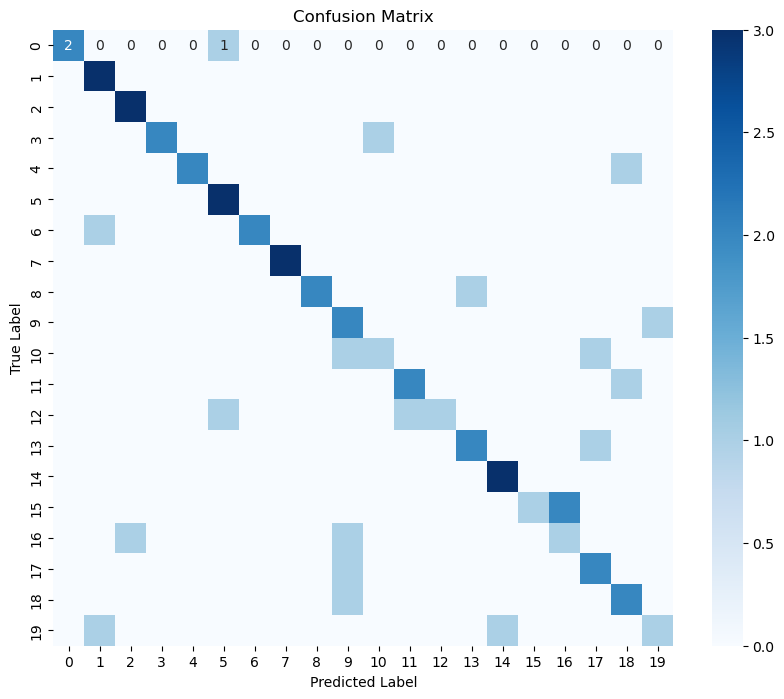

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    # Load the best model weights if saved
    model.load_state_dict(torch.load("best_resnet18.pth"))
    model.eval()

    all_preds = []
    all_labels = []

    # No gradient computation during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get the predictions
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_labels), yticklabels=range(num_labels))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function with your test dataloader
evaluate_model(model, test_loader)


In [51]:

for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)



for i in range(len(torch.max(outputs, 1)[1])):
    formatted_tensor = [f"{val:.2f}" for val in outputs[i].tolist()]
    print('True:',labels[i], ' - predicted:', torch.max(outputs, 1)[1][i], formatted_tensor)

True: tensor(4)  - predicted: tensor(9) ['-0.44', '-0.53', '0.84', '-0.66', '0.72', '0.77', '0.25', '-0.11', '-2.11', '2.24', '-0.86', '-0.52', '-0.18', '-0.24', '-1.03', '1.39', '0.08', '-0.80', '-0.63', '-0.94']
True: tensor(18)  - predicted: tensor(18) ['-2.32', '-1.56', '1.01', '1.58', '0.35', '-0.76', '-2.23', '0.30', '-0.18', '-0.23', '0.36', '1.02', '-0.43', '1.23', '-0.94', '1.10', '0.28', '0.02', '1.66', '-0.36']
True: tensor(17)  - predicted: tensor(13) ['-1.55', '-2.60', '-0.68', '1.82', '0.93', '-0.68', '-2.09', '1.36', '0.36', '-1.75', '1.74', '0.71', '0.11', '2.61', '-2.05', '0.89', '0.53', '0.39', '1.54', '-1.18']
True: tensor(7)  - predicted: tensor(18) ['-0.65', '-0.92', '0.70', '0.80', '-0.09', '0.40', '-0.79', '0.81', '-1.17', '-0.25', '-0.12', '1.41', '-0.14', '-0.48', '-1.54', '0.45', '0.70', '-0.95', '1.73', '-0.14']
True: tensor(11)  - predicted: tensor(11) ['-1.59', '-1.00', '-0.59', '0.62', '-0.16', '-0.85', '-0.72', '0.98', '-0.04', '0.29', '0.04', '1.40', '0.

In [48]:
for i in range(len(torch.max(outputs, 1)[1])):
    formatted_tensor = [f"{val:.2f}" for val in outputs[i].tolist()]
    print('True:',labels[i], ' - predicted:', torch.max(outputs, 1)[1][i], formatted_tensor)

True: tensor(4)  - predicted: tensor(9) ['-0.44', '-0.53', '0.84', '-0.66', '0.72', '0.77', '0.25', '-0.11', '-2.11', '2.24', '-0.86', '-0.52', '-0.18', '-0.24', '-1.03', '1.39', '0.08', '-0.80', '-0.63', '-0.94']
True: tensor(18)  - predicted: tensor(18) ['-2.32', '-1.56', '1.01', '1.58', '0.35', '-0.76', '-2.23', '0.30', '-0.18', '-0.23', '0.36', '1.02', '-0.43', '1.23', '-0.94', '1.10', '0.28', '0.02', '1.66', '-0.36']
True: tensor(17)  - predicted: tensor(13) ['-1.55', '-2.60', '-0.68', '1.82', '0.93', '-0.68', '-2.09', '1.36', '0.36', '-1.75', '1.74', '0.71', '0.11', '2.61', '-2.05', '0.89', '0.53', '0.39', '1.54', '-1.18']
True: tensor(7)  - predicted: tensor(18) ['-0.65', '-0.92', '0.70', '0.80', '-0.09', '0.40', '-0.79', '0.81', '-1.17', '-0.25', '-0.12', '1.41', '-0.14', '-0.48', '-1.54', '0.45', '0.70', '-0.95', '1.73', '-0.14']
True: tensor(11)  - predicted: tensor(11) ['-1.59', '-1.00', '-0.59', '0.62', '-0.16', '-0.85', '-0.72', '0.98', '-0.04', '0.29', '0.04', '1.40', '0.

In [29]:
outputs[0] + outputs[1]

tensor([-2.7647, -2.0875,  1.8545,  0.9179,  1.0721,  0.0081, -1.9767,  0.1883,
        -2.2914,  2.0137, -0.5033,  0.4946, -0.6050,  0.9940, -1.9738,  2.4961,
         0.3647, -0.7823,  1.0296, -1.2975], grad_fn=<AddBackward0>)